In [1]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
from shutil import copy, rmtree
import matplotlib
import datetime
from copy import deepcopy
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")
import sys, logging
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter

if "__file__" not in dir():

    root='/data'

    ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
    CommunNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
    CWD=os.getcwd()
    os.chdir(CommunNoteBookesPath)   
    %run Animal_Tags.ipynb
    %run UtilityTools.ipynb
    %run BatchRatBehavior.ipynb
    %run loadRat_documentation.ipynb
    %run plotRat_documentation_1_GeneralBehavior.ipynb
    %run plotRat_documentation_3_KinematicsInvestigation.ipynb
    %run Animal_Tags.ipynb
    %run RunBatchRat_3_CompareGroups.ipynb
    %run Lesion_Size.ipynb

    os.chdir(CWD)

    defaultParam={
        "binSize":0.25,
        "trialOffset":20., #max end of trial, in seconds (position will be cutted)
        "sigmaSmoothPosition":0.1,  #smooth the position
        #"sigmaSmoothPosition":0.33 for pavel dataType
        "treadmillRange":[0,90],
        "sigmaSmoothSpeed":0.3, #smooth the speed
        "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                      #min to correct start, max to correct jumps
        "pawFrequencyRange":[2.,10.],
        "startAnalysisParams":[10,0.2,0.5],
        "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
        "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked

        #parameter to detect end of trial (first position minima)
        "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
        "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
        "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
        }
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 13}

Early

In [9]:
def early_lesion_size_control(root,PerfParamToPlot,AnimalProfile, animalList):
    """
    loads lesion size and location of animals and returns corresponding 
    behavioral measures for those animals
    """
#     allFiles=HistologyExcel.read_all('/NAS02')

    size=[]
    loc=[]
    behav=[]
    animals=[]
    for animal in animalList:
        try:
            i=HistologyExcel('/NAS02',animal)
        except AssertionError as e:
            logging.warning(repr(e))
            continue
        except Exception as e:
            logging.error(f'{animal}: {repr(e)}')
            continue
        
        res=plot_learningCurves(root,animal=animal,PerfParamToPlot=PerfParamToPlot,profile=AnimalProfile,
                                stop_date='',redoPreprocess=False,
                                redoStat=True,override=False,plot=False,PrintWarning=False)[PerfParamToPlot[0]][20:30]

        try:
            t1=np.nanmean(res)
            t2=i.lesion_location()
            t3=i.lesion_size()
        except Exception as e:
            logging.warning(repr(e))
            continue
        behav.append(t1)
        loc.append(t2)
        size.append(t3)
        animals.append(animal)
    
    return behav, loc, size, animals    

In [10]:
if "__file__" not in dir():
    
    AnimalProfile={'Type':'Good',
#          'option': ['not used'],
         'rewardType':'Progressive',
         'initialSpeed':['10','0'],
         'Speed':'10',
         'Tag':['Early-Lesion_DS','Early-Lesion_DMS','Early-Lesion_DLS']
                  }
    
    PerfParamToPlot1 =['Forward Running Speed']
        
    animalList=batch_get_animal_list(root,AnimalProfile)
    
    behav1, loc1, size1, animals1= early_lesion_size_control(root,PerfParamToPlot1,AnimalProfile, animalList)

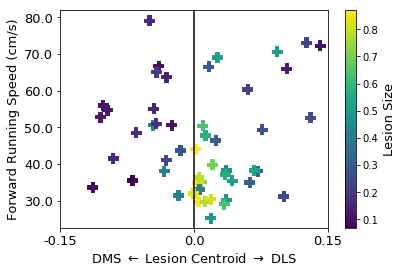

In [11]:
if "__file__" not in dir():
    cm = plt.cm.get_cmap('viridis')
    fig=plt.figure()
    ax=fig.add_subplot(111)
    sc=ax.scatter(loc1,behav1,c=size1,cmap=cm,s=100,marker='P')
    ax.set_ylabel("Forward Running Speed (cm/s)",fontdict=font)
    ax.set_xlabel(r'DMS $\leftarrow$ Lesion Centroid $\rightarrow$ DLS',fontdict=font)
#     ax.set_title('r='+str(np.corrcoef(behav,loc)[0,1])[:5]+', p='+str(scipy.stats.pearsonr(behav,loc)[1])[:5],fontdict=font);
    ax.axvline(0,color='k');
    ax.set_xlim([-.15,.15])
    ax.set_xticks([ax.get_xlim()[0],0,ax.get_xlim()[1]])
    ax.set_xticklabels(ax.get_xticks(),fontdict=font)
    ax.set_yticklabels(ax.get_yticks(),fontdict=font)
    cbAx=plt.colorbar(sc,ax=ax);
    cbAx.set_label("Lesion Size",fontdict=font)
    cbAx.set_ticks(np.arange(0,1,.1))
#     cbAx.set_ticklabels(cbAx.get_ticks())
#     for i, txt in enumerate(animals):
#         ax.annotate(txt[-3:], (loc[i], behav[i]))

# filename='/home/david/Mostafa/PhD/InmedDays2018/earlyLesionSize.svg'
# fig.savefig(filename,format='svg')

### Late

In [12]:
def late_lesion_size_control(root,PerfParamToPlot,profile1,profile2,param={}):
    """
    loads lesion size and location of animals and returns corresponding 
    behavioral measures for those animals
    use for late lesion animals
    """
    animalList=event_detect(root,profile1,profile2)[1].keys()
#     allFiles=HistologyExcel.read_all('/NAS02')
    
    size=[]
    loc=[]
    behav=[]
    animals=[]
    for animal in animalList:
        try:
            i=HistologyExcel('/NAS02',animal)
        except Exception as e:
            logging.error(f'{animal}: {repr(e)}')
            continue
        
        res1=plot_learningCurves(root,animal=animal,PerfParamToPlot=PerfParamToPlot,profile=profile1,
                                stop_date='',redoPreprocess=False,parameter=param,
                                redoStat=True,override=False,plot=False,PrintWarning=False)[PerfParamToPlot[0]][-5:]
        
        res2=plot_learningCurves(root,animal=animal,PerfParamToPlot=PerfParamToPlot,profile=profile2,
                                stop_date='',redoPreprocess=False,parameter=param,
                                redoStat=True,override=False,plot=False,PrintWarning=False)[PerfParamToPlot[0]][:5]


        try:
            t1=np.nanmean(res2)/np.nanmean(res1)
            t2=i.lesion_location()
            t3=i.lesion_size()
        except Exception as e:
            logging.warning(repr(e))
            continue
        behav.append(t1)
        loc.append(t2)
        size.append(t3)
        animals.append(animal)
    
    return behav, loc, size, animals

In [13]:
if "__file__" not in dir():
    profile1={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Control','Control-AfterBreak','Control-Late-NoTimeout-BackToTimeout',
                    'Control-NoTimeout-Control']
             }
    profile2={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Late-Lesion_DMS','Late-Lesion_DLS','Late-Lesion_DS',
                   'Late-Lesion_DMS-Sharp','Late-Lesion_DLS-Sharp','Late-Lesion_DS-Sharp']
             }
    
    _,sessionDic=event_detect(root,profile1,profile2)
    

    PerfParamToPlot=['Forward Running Speed']
    
    plotFunctionList=[]

    Behav, Loc, Size, Animals=late_lesion_size_control(root,PerfParamToPlot,profile1,profile2,param=defaultParam)

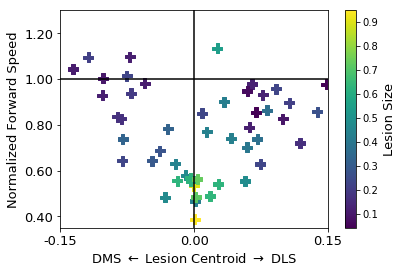

In [14]:
if "__file__" not in dir():
    cm = plt.cm.get_cmap('viridis')
    fig=plt.figure()
    ax=fig.add_subplot(111)
    sc=ax.scatter(Loc,Behav,c=Size,cmap=cm,s=100,marker='P')
    ax.set_ylabel("Normalized Forward Speed",fontdict=font)
    ax.set_xlabel(r'DMS $\leftarrow$ Lesion Centroid $\rightarrow$ DLS',fontdict=font)
#     ax.set_title('r='+str(np.corrcoef(Behav,Loc)[0,1])[:5]+', p='+str(scipy.stats.pearsonr(Behav,Loc)[1])[:5]);
    ax.axvline(0,color='k');
    ax.axhline(1,color='k');
    ax.set_xlim([-.15,.15])
    ax.set_ylim([.35,1.3])
    ax.set_xticks([ax.get_xlim()[0],0,ax.get_xlim()[1]])
    ax.set_xticklabels(ax.get_xticks(),fontdict=font)
    ax.set_yticklabels(ax.get_yticks(),fontdict=font)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cbAx=plt.colorbar(sc,ax=ax);
    cbAx.set_label("Lesion Size",fontdict=font)
    cbAx.set_ticks(np.arange(0,1,.1))
#     cbAx.set_ticklabels(cbAx.get_ticks())

#     for i, txt in enumerate(Animals):
#         ax.annotate(txt[-3:], (Loc[i], Behav[i]))

# filename='/home/david/Mostafa/PhD/InmedDays2018/lateLesionSize.svg'
# fig.savefig(filename,format='svg')